In [1]:
import pandas as pd
import datetime

from lib.ts_backtester import Backtester
from strategies.rsi_2.S_rsi_plot import plot

import pandas_ta as ta
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId

# Set Jupyter Notebook output mode parameters
# Used to avoid warnings
from tradeexecutor.backtest.notebook import setup_charting_and_output

setup_charting_and_output()

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

backtester = Backtester(
    candle_time_bucket=TimeBucket.h4,
    stop_loss_time_bucket=TimeBucket.m1,
    trading_pair=[(ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005)],
    # trading_pair=[
    #     (ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005),
    #     # (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
    # ],
    start_at=datetime.datetime(2021, 1, 1),
    end_at=datetime.datetime(2023, 8, 4),
    reserve_currency="USDC",
)

# try:
#     backtester
# except NameError:
#     print("backtester is not defined")
#     backtester = Backtester(
#         timeframe=TimeBucket.h4,
#         trading_pair=("WBNB", "BUSD"),
#         chain_id=ChainId.bsc,
#         exchange_slug="pancakeswap-v2",
#     )
#     timeframe=TimeBucket.h4,
#     trading_pair=("WBNB", "BUSD"),
#     chain_id=ChainId.bsc,
#     exchange_slug="pancakeswap-v2",
# )

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alpha/.tradingstrategy


  0%|          | 0/14342400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 54 trades
Total return: 21.42%
Max Drawdown: -7.2%


,0
Trading period length,147 days
Return %,21.42%
Annualised return %,53.18%
Cash at start,"$10,000.00"
Value at end,"$12,141.93"
Trade volume,"$605,960.55"
Position win percent,81.48%
Total positions,27
Won positions,22
Lost positions,5


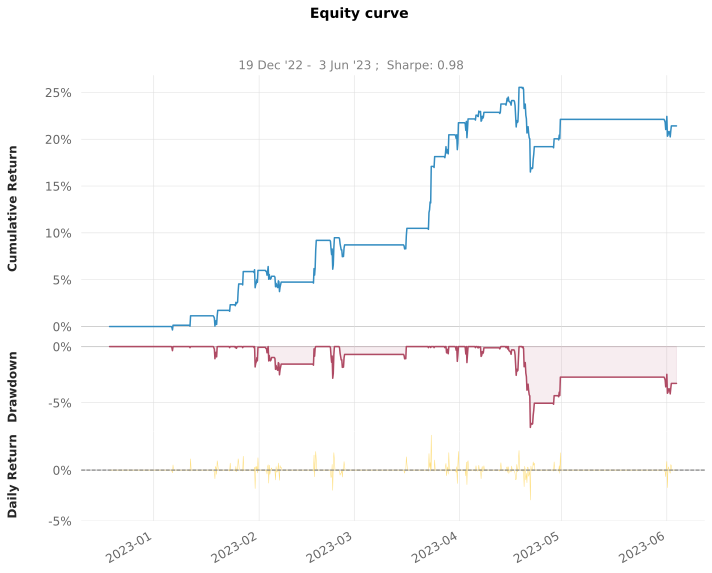

In [2]:
ma_long = 123
ma_short = 11
rsi_cutt = 13
atr_distance = 2.5
# Expected 5.28


import numpy as np


def get_signals(candles):
    close = candles["close"].iloc[-1]
    low = candles["low"].iloc[-1]

    # Calculate indicators
    sma_short = ta.sma(candles["close"], length=ma_short)
    sma_short = ta.sma(candles["close"], length=ma_short).iloc[-1]
    sma_long = ta.sma(candles["close"], length=ma_long).iloc[-1]
    rsi = ta.rsi(candles["close"], length=2).iloc[-1]
    atr = ta.atr(candles["high"], candles["low"], candles["close"], length=14).iloc[-1]

    # Calculate signals

    entry = close <= sma_short and close >= sma_long and rsi <= rsi_cutt
    exit = close > sma_short
    sl = low - atr * atr_distance
    sl_pct = float(round(sl / candles["open"].iloc[-1], 6))

    indicators = {
        "sma_short": sma_short,
        "sma_long": sma_long,
        "rsi": rsi,
        "atr": atr,
    }
    return entry, exit, sl, sl_pct, indicators


def calculate_size(state, close):
    cash = state.portfolio.get_current_cash()
    return cash * 0.99


current_sl = np.inf


def loop(timestamp, universe, state, pricing_model, cycle_debug_data):
    # The pair we are trading
    trades = []
    pair = universe.pairs.get_single()

    candles: pd.DataFrame = universe.candles.get_single_pair_data(
        timestamp, sample_count=ma_long
    )

    if len(candles) < ma_long:
        # Backtest starting.
        # By default get_single_pair_data() returns the candles prior to the `timestamp`,
        # the behavior can be changed with get_single_pair_data(allow_current=True).
        # At the start of the backtest, we do not have any previous candle available yet,
        # so we cannot ask the the close price.
        return trades

    current_price = candles["close"].iloc[-1]

    entry, exit, sl, sl_pct, indicators = get_signals(candles)
    global current_sl

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    buy_amount = calculate_size(state, current_price)

    if not position_manager.is_any_open():
        if entry:
            # print(sl)
            # sl = 0.98
            current_sl = sl
            trades += position_manager.open_1x_long(pair, buy_amount)
            # trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=sl_pct)
    else:
        if exit:
            current_sl = np.inf
            trades += position_manager.close_all()
        # elif current_price < current_sl:
        #     current_sl = np.inf
        #     trades += position_manager.close_all()

    plot(state, timestamp, indicators)

    return trades


# start_at = datetime.datetime(2021, 7, 1)
# start_at = datetime.datetime(2022, 8, 30)
start_at = datetime.datetime(2022, 12, 20)
end_at = datetime.datetime(2023, 6, 4)


backtester.backtest(start_at, end_at, loop)
backtester.stats()
backtester.general_stats()
# backtester.plot()

state = backtester.state
curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)